In [1]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F

In [2]:
raw = pd.read_csv('./data/BTC/BTC_Book_0.zip', compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

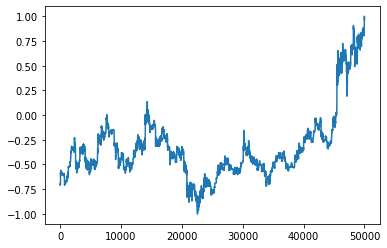

In [3]:
from sklearn.preprocessing import MinMaxScaler

price_scaler = MinMaxScaler(feature_range=(-1, 1))
mid_price = (prices['Bid_1_Price'] + prices['Ask_1_Price'])/2

mid_price_reshape = np.expand_dims(mid_price.values,1)
price_scaler.fit(mid_price_reshape)
mid_price_norm = price_scaler.transform(mid_price_reshape)
plt.plot(mid_price_norm.flatten())

#check proper scaling with data_min_

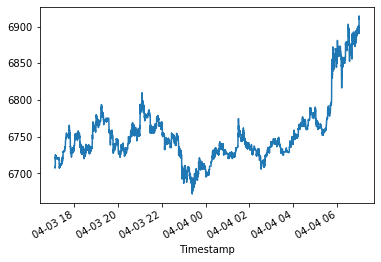

In [4]:
mid_price.plot()

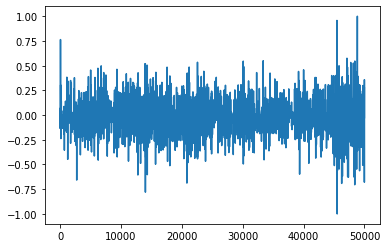

In [5]:
returns = mid_price.diff(1).dropna()
return_scaler = MinMaxScaler(feature_range=(-1,1))

returns_reshape = np.expand_dims(returns.values,1)
return_scaler.fit(returns_reshape)
returns_norm = return_scaler.transform(returns_reshape)
plt.plot(returns_norm.flatten())

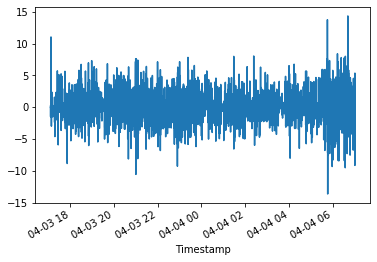

In [6]:
returns.plot()

In [7]:
subsets = rolling_window(mid_price_norm.flatten(),100)
X = subsets[:len(subsets)-1]
Y = subsets[1:]

X = torch.Tensor(np.expand_dims(X,2))
Y = torch.Tensor(np.expand_dims(Y,2))

print(X.shape)
print(Y.shape)

torch.Size([49900, 100, 1])
torch.Size([49900, 100, 1])


In [8]:
class RecurrentModel(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE):
        super(RecurrentModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True
        )
        
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # r_out, (h_n, h_c) = self.rnn(x, None)
            
        r_out, h = self.lstm(x, None) # None represents zero initial hidden state
            
        # to choose last time step of output, use -1 in center index
            
        out = self.out(r_out[:, :, :])
        return out

    
n_hidden = 20
price_model = RecurrentModel(1, n_hidden, 1, 1)
return_model = RecurrentModel(1, n_hidden, 1, 1)

In [9]:
def train_model(model, LR, n_epochs, X_BATCH, Y_BATCH):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all rnn parameters
    loss_func = nn.MSELoss()  

    all_losses = []
    all_accuracies = []

    for epoch in range(1,n_epochs+1):
        if epoch % 2 == 0:
            for param in optimizer.param_groups:
                param['lr'] = param['lr']/2 

        for i in range(len(X_BATCH)):

            train_x = X_BATCH[i]
            train_y = Y_BATCH[i]

            output = model(train_x)
            loss = loss_func(output, train_y)                # compute loss                      
            optimizer.zero_grad()                            # clear gradients for this training step
            loss.backward()                                  # backpropagation, compute gradients
            optimizer.step()                                 # apply gradient step

            all_losses.append(loss.item())                   #track loss

    #     #compute accuracy
    #     acc_output = rnn(b_x)
    #     pred_y = torch.max(acc_output,1)[1].data.numpy().squeeze()
    #     target = torch.max(b_y,1)[1].data.numpy().squeeze()
    #     train_accuracy = sum(pred_y==target)/b_y.size(0)

            #print info
            print("Epoch: ", epoch, "| train loss: %.4f" % loss.item())#, "| train accuracy: %.8f" % train_accuracy)

    return all_losses, all_accuracies

Epoch:  1 | train loss: 0.5886
Epoch:  1 | train loss: 0.0862
Epoch:  1 | train loss: 1.2291
Epoch:  1 | train loss: 0.4015
Epoch:  1 | train loss: 0.0134
Epoch:  1 | train loss: 0.1271
Epoch:  1 | train loss: 0.1315
Epoch:  1 | train loss: 0.1026
Epoch:  1 | train loss: 0.1825
Epoch:  1 | train loss: 0.2343
Epoch:  1 | train loss: 0.1538
Epoch:  1 | train loss: 0.1342
Epoch:  1 | train loss: 0.0308
Epoch:  1 | train loss: 0.0032
Epoch:  1 | train loss: 0.0032
Epoch:  1 | train loss: 0.0401
Epoch:  1 | train loss: 0.0154
Epoch:  1 | train loss: 0.0170
Epoch:  1 | train loss: 0.0030
Epoch:  1 | train loss: 0.0240
Epoch:  1 | train loss: 0.0164
Epoch:  1 | train loss: 0.0353
Epoch:  1 | train loss: 0.0203
Epoch:  1 | train loss: 0.0152
Epoch:  1 | train loss: 0.0038
Epoch:  1 | train loss: 0.0314
Epoch:  1 | train loss: 0.0229
Epoch:  1 | train loss: 0.0297
Epoch:  1 | train loss: 0.1905
Epoch:  1 | train loss: 0.1109
Epoch:  1 | train loss: 0.0760
Epoch:  1 | train loss: 0.0211
Epoch:  

Epoch:  3 | train loss: 0.0002
Epoch:  3 | train loss: 0.0029
Epoch:  3 | train loss: 0.0093
Epoch:  3 | train loss: 0.0135
Epoch:  3 | train loss: 0.0153
Epoch:  3 | train loss: 0.0180
Epoch:  3 | train loss: 0.0175
Epoch:  3 | train loss: 0.0077
Epoch:  3 | train loss: 0.0018
Epoch:  3 | train loss: 0.0001
Epoch:  3 | train loss: 0.0004
Epoch:  3 | train loss: 0.0015
Epoch:  3 | train loss: 0.0057
Epoch:  3 | train loss: 0.0096
Epoch:  3 | train loss: 0.0116
Epoch:  3 | train loss: 0.0081
Epoch:  3 | train loss: 0.0045
Epoch:  3 | train loss: 0.0047
Epoch:  3 | train loss: 0.0019
Epoch:  3 | train loss: 0.0012
Epoch:  3 | train loss: 0.0017
Epoch:  3 | train loss: 0.0008
Epoch:  3 | train loss: 0.0007
Epoch:  3 | train loss: 0.0004
Epoch:  3 | train loss: 0.0027
Epoch:  3 | train loss: 0.0052
Epoch:  3 | train loss: 0.0030
Epoch:  3 | train loss: 0.0040
Epoch:  3 | train loss: 0.0052
Epoch:  3 | train loss: 0.0030
Epoch:  3 | train loss: 0.0029
Epoch:  3 | train loss: 0.0061
Epoch:  

Epoch:  6 | train loss: 0.0007
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0008
Epoch:  6 | train loss: 0.0007
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0008
Epoch:  6 | train loss: 0.0033
Epoch:  6 | train loss: 0.0031
Epoch:  6 | train loss: 0.0058
Epoch:  6 | train loss: 0.0124
Epoch:  6 | train loss: 0.0037
Epoch:  6 | train loss: 0.0006
Epoch:  6 | train loss: 0.0001
Epoch:  6 | train loss: 0.0010
Epoch:  6 | train loss: 0.0010
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0012
Epoch:  6 | train loss: 0.0013
Epoch:  6 | train loss: 0.0014
Epoch:  6 | train loss: 0.0013
Epoch:  6 | train loss: 0.0012
Epoch:  6 | train loss: 0.0010
Epoch:  6 | train loss: 0.0008
Epoch:  6 | train loss: 0.0007
Epoch:  6 | train loss: 0.0005
Epoch:  6 | train loss: 0.0003
Epoch:  

Epoch:  8 | train loss: 0.0038
Epoch:  8 | train loss: 0.0022
Epoch:  8 | train loss: 0.0020
Epoch:  8 | train loss: 0.0016
Epoch:  8 | train loss: 0.0024
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0002
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0006
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0006
Epoch:  9 | train loss: 0.0006
Epoch:  9 | train loss: 0.0006
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0005
Epoch:  9 | train loss: 0.0004
Epoch:  9 | train loss: 0.0004
Epoch:  9 | train loss: 0.0007
Epoch:  9 | train loss: 0.0010
Epoch:  9 | train loss: 0.0010
Epoch:  9 | train loss: 0.0017
Epoch:  9 | train loss: 0.0010
Epoch:  9 | train loss: 0.0008
Epoch:  9 | train loss: 0.0003
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0002
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0001
Epoch:  9 | train loss: 0.0003
Epoch:  9 | train loss: 0.0003
Epoch:  9 | train loss: 0.0003
Epoch:  

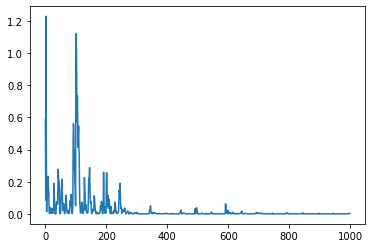

In [10]:
losses, accuracies = train_model(price_model, 
                                 LR=0.05, 
                                 n_epochs=10, 
                                 X_BATCH = np.split(X,100), 
                                 Y_BATCH = np.split(Y, 100)
                                )

plt.plot(losses)

In [11]:
out = price_model(X)
out_np = out.detach().numpy().squeeze()

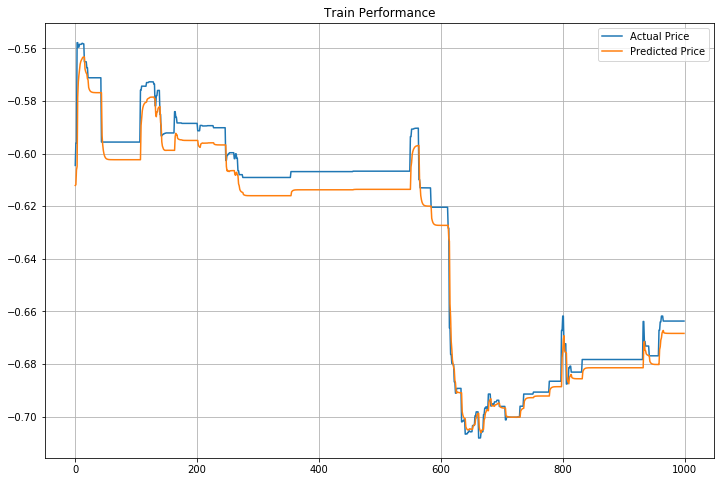

In [12]:
start = 0
window = 1000

fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(mid_price_norm.flatten()[start + 100:start + 100 + window])
ax.plot(out_np[:,-1][start:start + window])

ax.set_title('Train Performance')
ax.legend(['Actual Price','Predicted Price'])
ax.grid('on')

In [13]:
#### TEST

raw = pd.read_csv('./data/BTC/BTC_Book_1.zip', compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

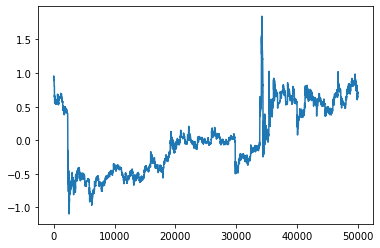

In [14]:
mid_price = (prices['Bid_1_Price'] + prices['Ask_1_Price'])/2

mid_price_reshape = np.expand_dims(mid_price.values,1)


mid_price_norm = price_scaler.transform(mid_price_reshape)

plt.plot(mid_price_norm.flatten())

In [15]:
subsets = rolling_window(mid_price_norm.flatten(),100)
X = subsets[:len(subsets)-1]
X = torch.Tensor(np.expand_dims(X,2))
print(X.shape)

torch.Size([49900, 100, 1])


In [16]:
out = price_model(X)
out_np = out.detach().numpy().squeeze()

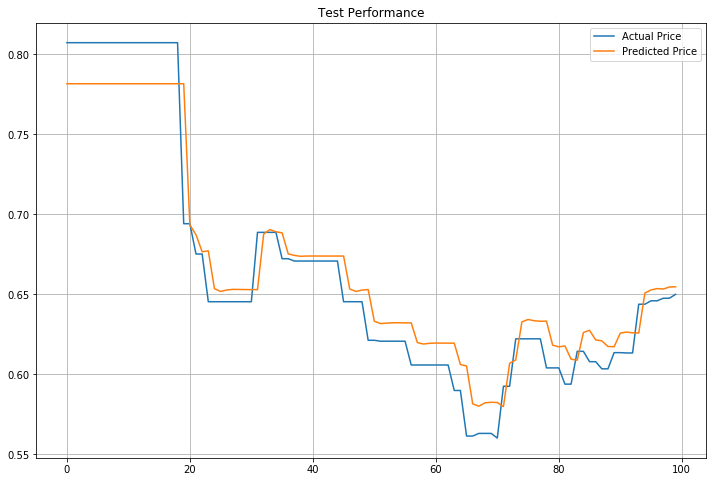

In [17]:
start = 0
window = 100

fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(mid_price_norm.flatten()[start + 100:start + 100 + window])
ax.plot(out_np[:,-1][start:start + window])

ax.set_title('Test Performance')
ax.legend(['Actual Price','Predicted Price'])
ax.grid('on')

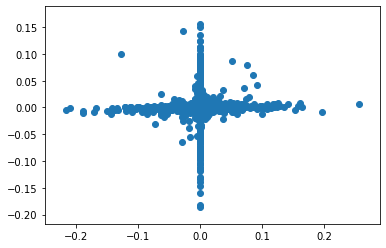

In [18]:
x = np.diff(mid_price_norm.flatten()[100:])
y = np.diff(out_np[:,-1])
plt.scatter(x,y)